#**Integrantes**

##**Grupo 10**<br>
Dairo Alberto Cuervo Garcia<br>
Yeison Alexander Florez Calderon<br>
Diego Alejandro Lopez Saldarriaga<br>
Christian Quintero Arias<br>

# **Trabajo Final CRP (CNN - SVM - Arboles de decisión)**

###**Problema:**<br>
Una fundación de protección animal (Gatos y Perros), quiere instalar dispensadores de comida para los Gatos y Perros en situación de calle en la ciudad de Medellín, para esto requieren identificar si el animal que se acerca al dispensador es un perro o un gato y de acuerdo a la imagen capturada, entregar el alimento adecuado.<br>
###**Solución:**<br>
Se implementará un dispensador de comidas con sistema de cámara y sensor de proximidad, el cual tomará una imagen cuando algo se acerque, identificará el animal y procederá a entregar el alimento acorde. Para esto se evaluarán 3 metodos (CNN - SVM - Arboles de decisión) de detección de imágenes y se utilizará la de mayor precisión. Para el método de SVM y arbol de decisión se realizó un preprocesamiento de la imágen, en los cuales se aplica ecualización e identificación de bordes, por el contrario para CNN solo se convierte la imágen a escala de grises.<br>
###**Conclusión:**<br>
* Dado que la red neuronal convolucional obtuvo mayor precisión que los otros 2 modelos, se seleccionará como el modelo a implementar en el sistema de detección para los dispensadores que instalará la fundación de protección animal.
* Debido a que la red neuronal extrae de forma más eficiente las caracteristicas, este tuvo ventaja sobre los demás modelos.
* Con la red neuronal se tuvieron diversos inconvenientes en cuanto sobre-ajuste,dado que el modelo no generalizaba lo suficiente, sin embargo, a través de técnicas de regularización se logró controlar el aprendizaje de la red.
* Computacionalente la red neuronal obtuvo una mayor relacion costo/beneficio (costo computacionar y mejor accuracy).
* A diferencia de la red neuronal, los otros dos modelos requirieron pre-procesamiento adicional para extraer las caracteristicas de las imágenes, gracias a esto se logró obtener un mejor resultado que con los datos sin procesar, sin embargo los resultados obtenidos fueron inferiores a los de la red neuronal.
* La maquina de soporte vectorial fue la que obtuvo peor costo/beneficio, computacionalmente hablando.
* A partir del proceso de iteración sobre la profundidad del arbol, se encontró que a mayor profundidad aumentaba la probabilidad de un sobre-ajuste.

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/Datasets/cat-dog.zip -d /content/

In [ ]:
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm #barra de progreso
from glob import glob

from skimage import data, io, filters, exposure, segmentation, color
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from skimage.future import graph
import random

import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization


import seaborn as sns; sns.set()


Definición de Funciones

In [ ]:
#Obtención y preprocesamiento de imágenes
def get_data(folder, isCNN):
  X=[]
  y=[]
 
  for folderName in os.listdir(folder):
    if not folderName.startswith('.'):
      if folderName in ['cats']:
        label=0
      elif folderName in ['dogs']:
        label=1
      else:
        label=2
 
      for image_filename in tqdm(os.listdir(folder+folderName)):
        img_file = cv2.imread(folder+folderName+'/'+image_filename)
        if img_file is not None:
          img_file = resize(img_file, (size_image_xy,size_image_xy,3), mode='constant', anti_aliasing=True)
          img_file = rgb2gray(img_file)

          if not isCNN:
            #Equalización y Bordes
            img_file = exposure.equalize_hist(img_file)
            img_file = filters.sobel(img_file)

          img_arr = np.asarray(img_file)
          X.append(img_arr)
          y.append(label)
  X = np.asarray(X)
  y = np.asarray(y)
  return X,y


#Histograma de Imagen
def  plotHistogram(a):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.hist(a.ravel(),bins=255)
  plt.subplot(1,2,2)
  plt.imshow(a, cmap='gray', vmin=0, vmax=1)
  plt.show()

#Matriz de confusión
def mostrar_resultados(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    a=conf_matrix[0,0]
    b=conf_matrix[0,1]
    c=conf_matrix[1,0]
    d=conf_matrix[1,1]
    print("Total de datos: ",(a+b+c+d))
    print("Total Perros: ",c+d)
    print("Aciertos: ",a+d," ",round((a+d)/(a+b+c+d),2)*100,"%")
    print("Fallos: ",b+c," ",round((b+c)/(a+b+c+d),2)*100,"%")
    print("Perros acertados: ",d," ",round((d)/(c+d),2)*100,"%")
    print("Perros fallidos: ",c," ",round((c)/(c+d),2)*100,"%")
    print("Gatos fallidos: ",b," ",round((b)/(b+d),2)*100,"%")  
    print("Gatos acertados: ",a," ",round((a)/(a+b),2)*100,"%")

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

#Se plotean imágenes al azar para observar su complejidad
def plotConjuntImages(multipleImages):
  i_=0
  plt.rcParams['figure.figsize'] = (20.0,20.0)
  plt.subplots_adjust(wspace=0,hspace=0)
  for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im,(128,128))
    plt.subplot(5,5,i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    i_+=1

In [ ]:
#Definición de variables
test_dir = "/content/test_set/test_set/"
train_dir = "/content/training_set/training_set/"
multipleImagesDogs = glob('/content/training_set/training_set/dogs/**')
multipleImagesCats = glob('/content/training_set/training_set/cats/**')
size_image_xy=128
dim = 1

Almacenamiento de datos para red Neuronal, Máquina de soporte vectorial y Arbol de decisión

In [ ]:
LOAD_FROM_IMAGES = True
if LOAD_FROM_IMAGES:
  #cargamos imágenes a los arrays

  #CNN
  X_train, y_train = get_data(train_dir, isCNN=True)
  X_test, y_test = get_data(test_dir, isCNN=True)
  #grabamos los arrays en archivos
  np.save('/content/xtrain.npy',X_train)
  np.save('/content/ytrain.npy',y_train)
  np.save('/content/xtest.npy',X_test)
  np.save('/content/ytest.npy',y_test)

  #SVM - TREE
  X_train_, y_train_ = get_data(train_dir, isCNN=False)
  X_test_, y_test_ = get_data(test_dir, isCNN=False)
  np.save('/content/xtrain_.npy',X_train_)
  np.save('/content/ytrain_.npy',y_train_)
  np.save('/content/xtest_.npy',X_test_)
  np.save('/content/ytest_.npy',y_test_)
 
else:
  #cargamos los arrays anteriormente grabados
  #CNN
  X_train = np.load('/content/xtrain.npy')
  y_train = np.load('/content/ytrain.npy')
  X_test = np.load('/content/xtest.npy')
  y_test = np.load('/content/ytest.npy')
  #SVM - TREE
  X_train_ = np.load('/content/xtrain_.npy')
  y_train_ = np.load('/content/ytrain_.npy')
  X_test_ = np.load('/content/xtest_.npy')
  y_test_ = np.load('/content/ytest_.npy')

100%|██████████| 1013/1013 [00:20<00:00, 49.72it/s]


Se observa balanceo entre los datos para cada etiqueta, en este caso, para la cantidad de imágenes de gatos y perros<br>
Gatos -> 4000<br>
Perros -> 4000<br>
Nulos -> 0<br>

{0: 'cat', 1: 'dog', 2: 'NULL'}


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


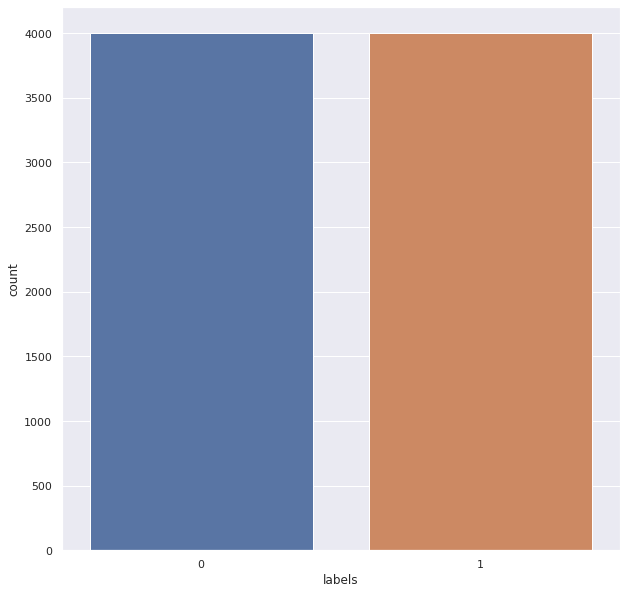

In [ ]:
plt.figure(figsize=(10,10))
map_characters={0:'cat', 1:'dog', 2:'NULL'}
dict_characters=map_characters

df = pd.DataFrame()
df['labels']=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

## **Pre-procesamiendo de prueba**<br>

Durante las pruebas realizas se llevaron a cabo diversos preprocesamientos para la extracción de caracteristicas para los métodos de SVM y Arbol de decisión. Se observa que de las caracteristicas mostradas, las que más detallan el objetivo de este trabajo son la ecualización y la deteccón de bordes, por tanto, este será el preprocesamiento seleccionado para ingresar en los entrenamientos para SVM y Arbol de decisión.

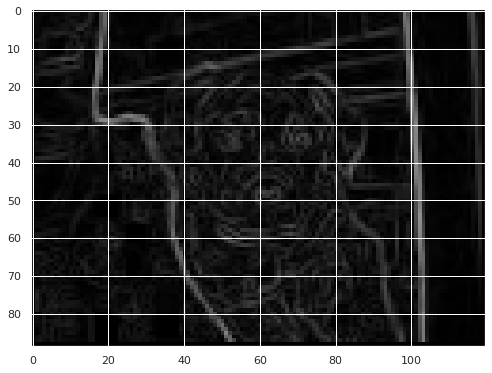

In [ ]:
#Ecualización y Detección de bordes
img_file = cv2.imread(multipleImagesDogs[0])
img_file = rgb2gray(img_file)
img_file = exposure.equalize_hist(img_file)
img_file = filters.sobel(img_file)
plt.figure(figsize=(7,7))
io.imshow(img_file)
io.show()

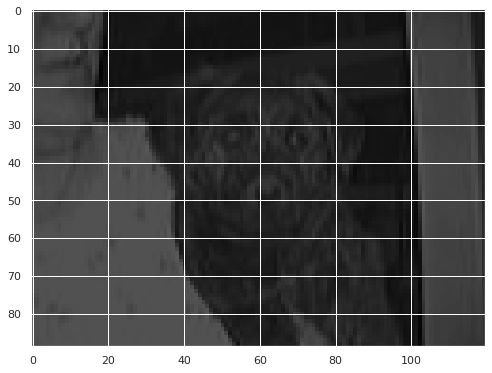

In [ ]:
#Filtro de textura por frecuencia
img_file = cv2.imread(multipleImagesDogs[0])
img_file = rgb2gray(img_file)
filt_real, filt_imag = filters.gabor(img_file, frequency=0.7)
plt.figure(figsize=(7,7))
io.imshow(filt_real)
io.show()

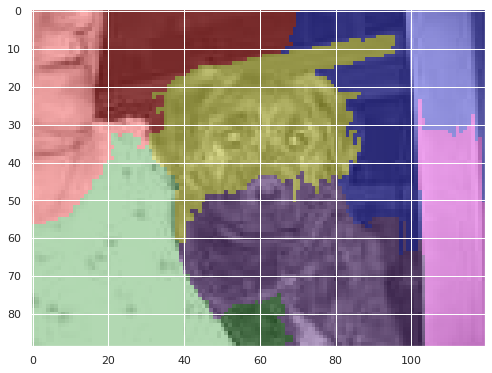

In [ ]:
#Filtro de segmentación
img_file = cv2.imread(multipleImagesDogs[0])
labels = segmentation.slic(img_file,n_segments=10)
out = color.label2rgb(labels, img_file)
g = graph.rag_mean_color(img_file, labels)
plt.figure(figsize=(7,7))
io.imshow(out)
io.show()

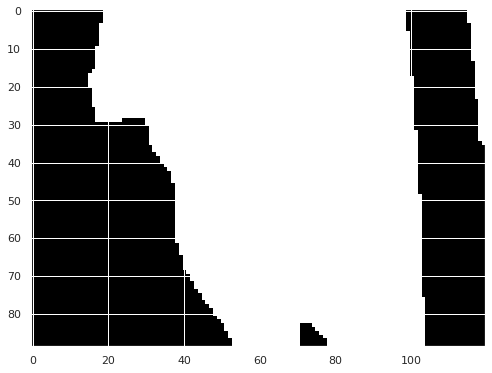

In [ ]:
#Filtro de segmentación para objetos sin limites claramente definidos
img_file = cv2.imread(multipleImagesDogs[0])
img_file = rgb2gray(img_file)
img_file = segmentation.chan_vese(img_file)
plt.figure(figsize=(7,7))
io.imshow(img_file)
io.show()

**Complejidad de las imágenes**<br>
Se observa que la complejidad de las imágenes es bastante elevada, debido a que el ambiente donde fueron tomadas es totalmente aleatorio, por tanto, la extracción de caracteristicas debe ser lo suficientemente buena como para comparar entre imágenes de perros y gatos con fotos totalmente diferentes.

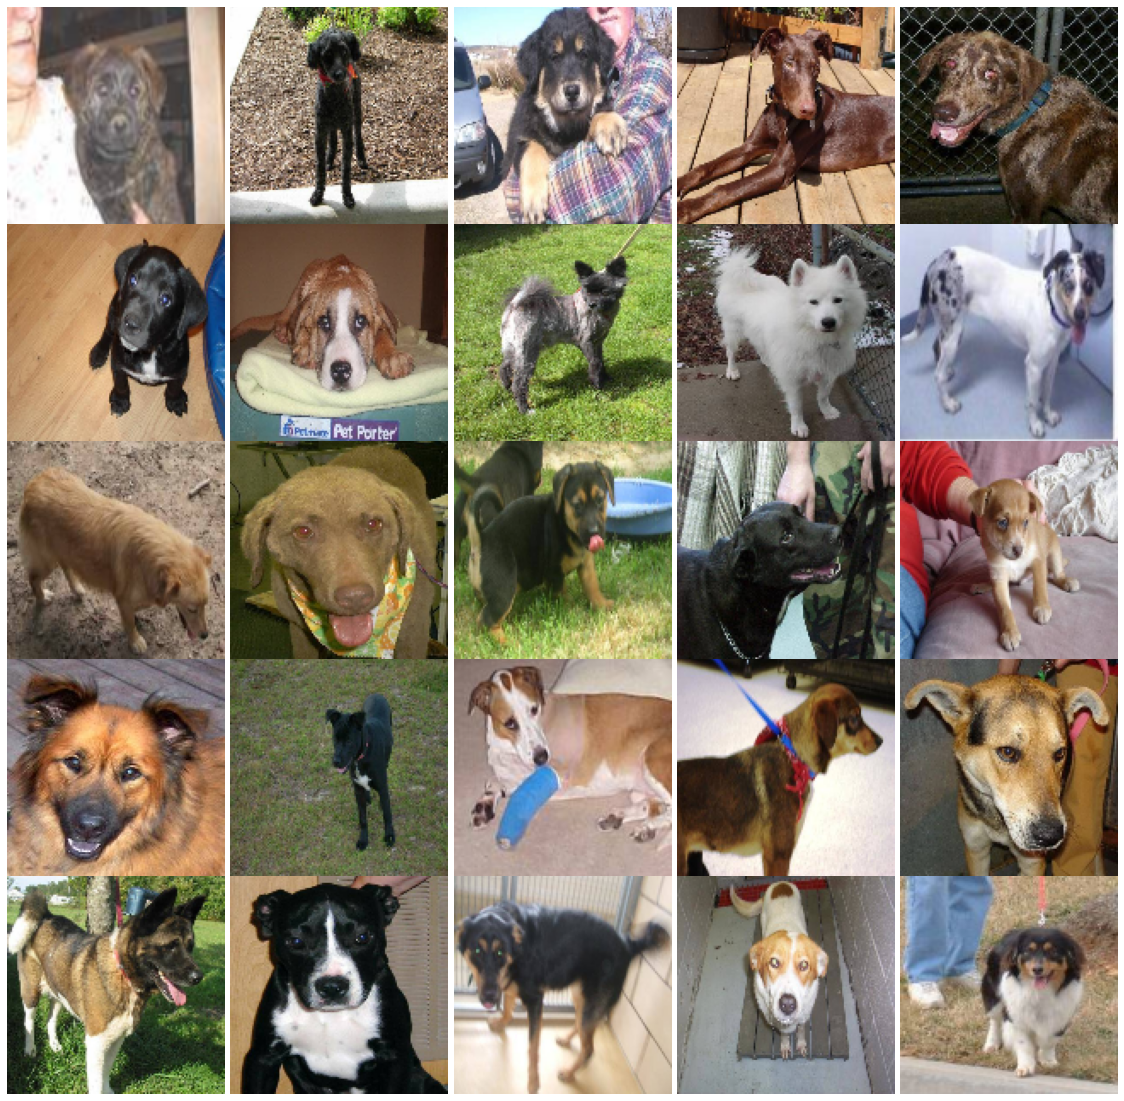

In [ ]:
plotConjuntImages(multipleImagesDogs)

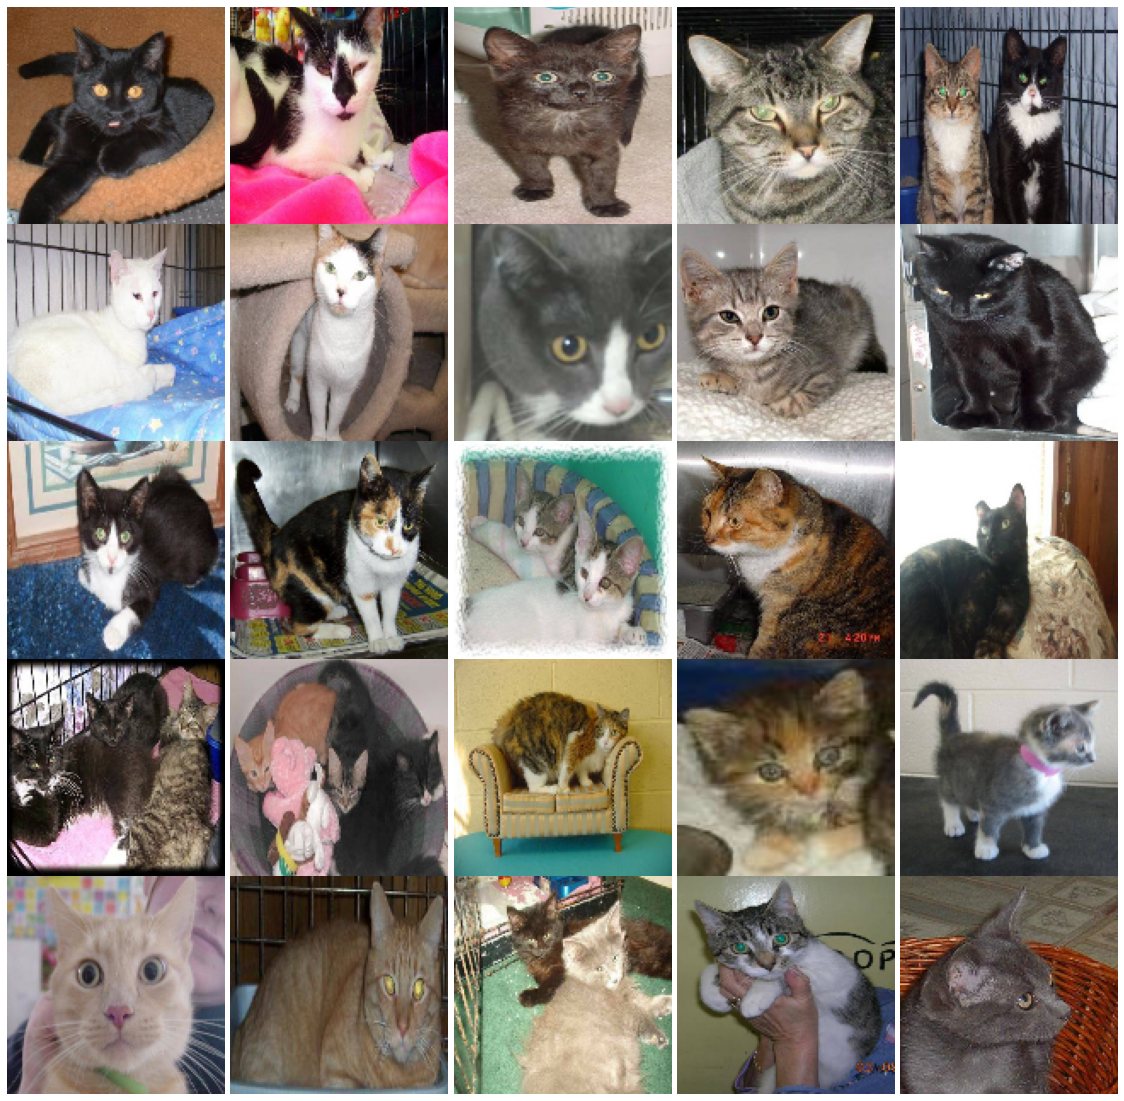

In [ ]:
plotConjuntImages(multipleImagesCats)

##**Definición de modelos**

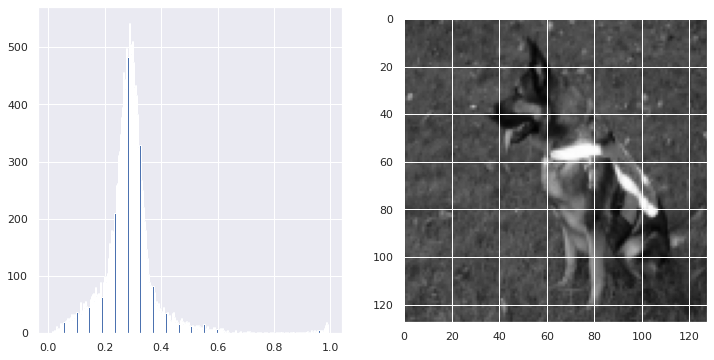

In [ ]:
#Se observa histograma para datos en la red neuronal
plotHistogram(X_train[1])

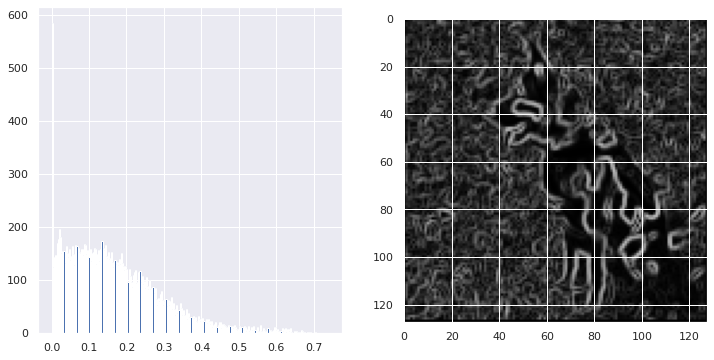

In [ ]:
#Se observa histograma para datos en la SVM y Arbol decisión
plotHistogram(X_train_[1])

In [ ]:
X_train.shape

###**Modelo 1 - Red Neuronal**

In [ ]:
X_trainCNN = X_train
y_trainCNN = y_train
X_testCNN = X_test
y_testCNN = y_test

In [ ]:
#Redimensionamiento
X_trainReshaped = X_trainCNN.reshape(len(X_trainCNN),size_image_xy,size_image_xy,dim)
X_testReshaped = X_testCNN.reshape(len(X_testCNN),size_image_xy,size_image_xy,dim)
X_trainReshaped.shape

(8005, 128, 128, 1)

In [ ]:
#Segmentación de los conjuntos de Validación y Test
X_testCNN, X_val, y_testCNN, Y_val = train_test_split(X_testReshaped, y_testCNN, test_size = 0.5, random_state=42)
print(X_testCNN.shape)
print(X_val.shape)

(1011, 128, 128, 1)
(1012, 128, 128, 1)


Para la definición de la red neuronal se utilizaron 10 capas conformadas por convoluciones con funcion de activación 'relu' y pooling. Al final de los procesos se utilizó un DropOut del 85% para aplanar la curva de aprendizaje del modelo y evitar un sobrea-juste, finalmente dos capas densamente enlazadas, teniendo la capa final dos neuronas de salida con función de activación 'sigmoid'

In [ ]:
#Definición del modelo para la red neuronal convolucional
model = models.Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(size_image_xy,size_image_xy,dim)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.85))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 12, 12, 128)     

In [ ]:
#Ajuste del modelo
chekpoint_path = '/content/checkpoint'
cp_callbacks = tf.keras.callbacks.ModelCheckpoint(
    chekpoint_path, 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='max') #Esto es para almacenar los pesos dado que pueden ser muyy valiosos 
history=model.fit( X_trainReshaped,y_trainCNN, epochs=40,validation_data = (X_val,Y_val),callbacks=[cp_callbacks])
model.load_weights(chekpoint_path)

Epoch 1/40
251/251 [==============================] - 5s 19ms/step - loss: 0.6964 - accuracy: 0.5116 - val_loss: 0.6870 - val_accuracy: 0.4901

Epoch 00001: val_accuracy improved from -inf to 0.49012, saving model to /content/checkpoint
Epoch 2/40
251/251 [==============================] - 4s 18ms/step - loss: 0.6872 - accuracy: 0.5421 - val_loss: 0.6818 - val_accuracy: 0.5761

Epoch 00002: val_accuracy improved from 0.49012 to 0.57609, saving model to /content/checkpoint
Epoch 3/40
251/251 [==============================] - 4s 18ms/step - loss: 0.6793 - accuracy: 0.5697 - val_loss: 0.6558 - val_accuracy: 0.6334

Epoch 00003: val_accuracy improved from 0.57609 to 0.63340, saving model to /content/checkpoint
Epoch 4/40
251/251 [==============================] - 4s 18ms/step - loss: 0.6642 - accuracy: 0.6049 - val_loss: 0.6267 - val_accuracy: 0.6680

Epoch 00004: val_accuracy improved from 0.63340 to 0.66798, saving model to /content/checkpoint
Epoch 5/40
251/251 [=======================

In [ ]:
#Resumen resultado de validación
test_loss, test_acc = model.evaluate(X_val, Y_val)
print("Perdida: ",test_loss, " Prescisión: ",test_acc)

32/32 [==============================] - 0s 7ms/step - loss: 0.3186 - accuracy: 0.8844
Perdida:  0.3186100423336029  Prescisión:  0.8843873739242554


In [ ]:
#Predicción
y_predict = model.predict(X_testCNN)
y_predict = np.argmax(y_predict, axis=1)
print(y_predict)
print(y_testCNN)
print("Accuracy Score")
print(accuracy_score(y_testCNN,y_predict))
print("Classification Report")
print(classification_report(y_testCNN,y_predict))

[0 0 0 ... 1 0 0]
[0 1 1 ... 1 0 0]


446
70
67
428
Total de datos:  1011
Total Perros:  495
Aciertos:  874   86.0 %
Fallos:  137   14.000000000000002 %
Perros acertados:  428   86.0 %
Perros fallidos:  67   14.000000000000002 %
Gatos fallidos:  70   14.000000000000002 %
Gatos acertados:  446   86.0 %


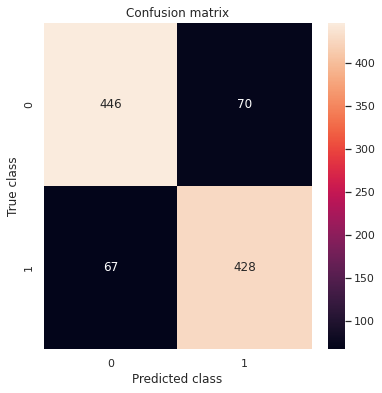

In [ ]:
#Matriz de confusión
mostrar_resultados(y_testCNN, y_predict)

Las gráficas siguientes muestran los resultados de las funciones de perdida para entrenamiento y test, al igual que el Accuracy para estos mismos. Se observa que para la mejor epoca seleccionada por el sistema, la distancia (error) entre las dos gráficas no exede el 5%. Lo cual indica que hasta este punto no hay sobre-ajuste de los datos. Además de que gráficamente se muestra una tendencia ajustada (sin picos). Finalmente se concluye que se tuvo un buen proceso durante el entrenamiento y una precisión de validación admisible.

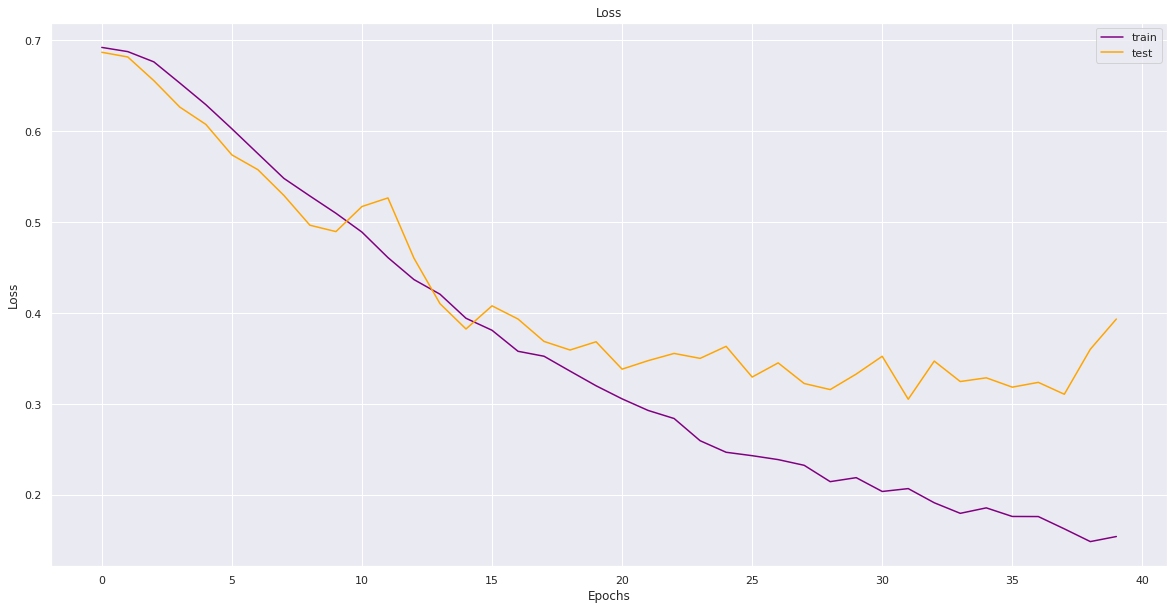

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

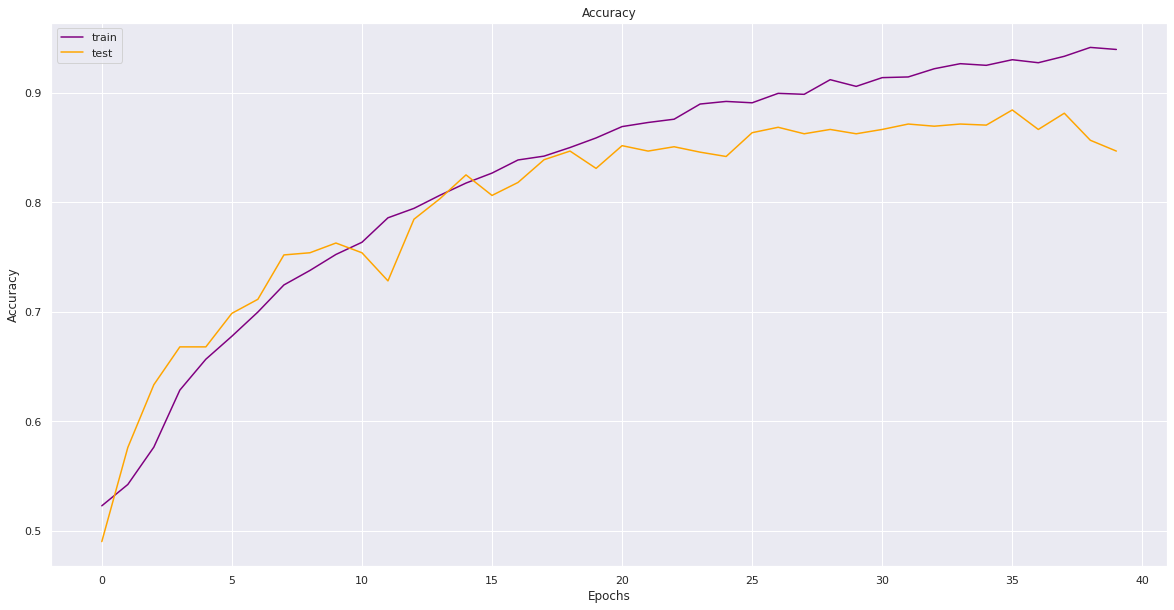

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

###**Modelo 2 - SVM - Maquinas de Soporte Vectorial**

In [ ]:
X_trainSVM = X_train_
y_trainSVM = y_train_
X_testSVM = X_test_
y_testSVM = y_test_

In [ ]:
X_trainSVM.shape

(8005, 128, 128)

In [ ]:
#Redimensionamiento
X_trainReshaped = X_trainSVM.reshape(len(X_trainSVM),size_image_xy*size_image_xy)
X_testReshaped = X_testSVM.reshape(len(X_testSVM),size_image_xy*size_image_xy)
print(X_trainSVM.shape)
print(X_trainReshaped.shape)

(8005, 128, 128)
(8005, 16384)


Para los parámetros de la máquina de soporte se encontró por iteración que el mejor resultado se obtuvo a partir del kerner "rbf" y una restricción de 35 (C)

In [ ]:
#Configuración y ajuste del modelo
svc = SVC(kernel="rbf", C=35, random_state=0)
svc.fit(X_trainReshaped, y_trainSVM)

SVC(C=35, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
#Predicción
yfit = svc.predict(X_testReshaped)
print(yfit)
print(y_testSVM)
print("Accuracy Score")
print(accuracy_score(y_testSVM,yfit))
print("Classification Report")
print(classification_report(y_testSVM,yfit))

612
399
363
649
Total de datos:  2023
Total Perros:  1012
Aciertos:  1261   62.0 %
Fallos:  762   38.0 %
Perros acertados:  649   64.0 %
Perros fallidos:  363   36.0 %
Gatos fallidos:  399   38.0 %
Gatos acertados:  612   61.0 %


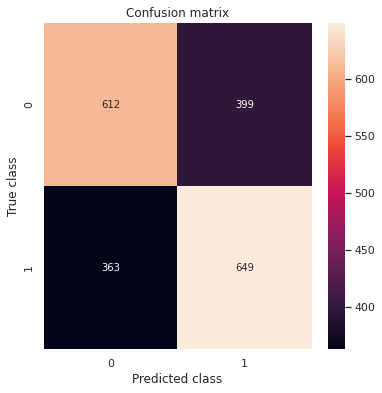

In [ ]:
#Matriz de confusión
mostrar_resultados(y_testSVM, yfit)

###**Modelo 3 - Arbol de decisión**

In [ ]:
X_trainTREE = X_train_
y_trainTREE = y_train_
X_testTREE = X_test_
y_testTREE = y_test_

In [ ]:
#Redimensionamiento
X_trainReshaped = X_trainTREE.reshape(len(X_trainTREE),size_image_xy*size_image_xy)
X_testReshaped = X_testTREE.reshape(len(X_testTREE),size_image_xy*size_image_xy)
print(X_trainTREE.shape)
print(X_trainReshaped.shape)

(8005, 128, 128)
(8005, 16384)


Debido a que la profundidad del arbol podría afectar el rendimiento del mismo, se escogió un rango pequeño. Se observa que dentro dentro de las iteraciones relaizadas, la profundidad que obtuvo mejores resultados fue de 4. A pesar de que la profundidad 8 obtuvo igual resultado, se atribuye más confiabilidad a la menor profundidad debido al posible sobre-ajuste.

1
670
341
538
474
Total de datos:  2023
Total Perros:  1012
Aciertos:  1144   56.99999999999999 %
Fallos:  879   43.0 %
Perros acertados:  474   47.0 %
Perros fallidos:  538   53.0 %
Gatos fallidos:  341   42.0 %
Gatos acertados:  670   66.0 %


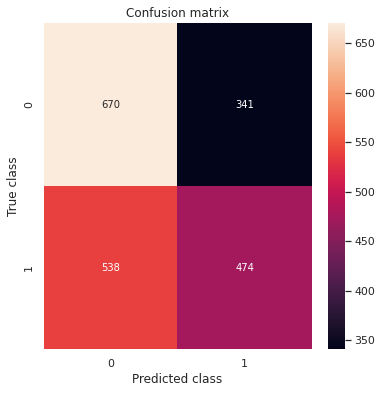

2
385
626
213
799
Total de datos:  2023
Total Perros:  1012
Aciertos:  1184   59.0 %
Fallos:  839   41.0 %
Perros acertados:  799   79.0 %
Perros fallidos:  213   21.0 %
Gatos fallidos:  626   44.0 %
Gatos acertados:  385   38.0 %


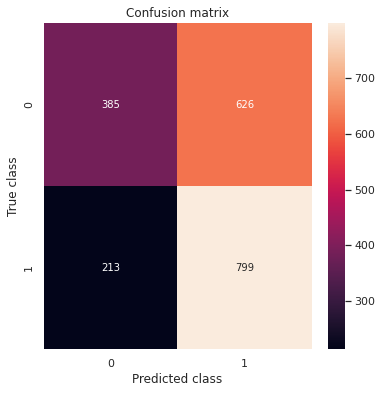

3
484
527
304
708
Total de datos:  2023
Total Perros:  1012
Aciertos:  1192   59.0 %
Fallos:  831   41.0 %
Perros acertados:  708   70.0 %
Perros fallidos:  304   30.0 %
Gatos fallidos:  527   43.0 %
Gatos acertados:  484   48.0 %


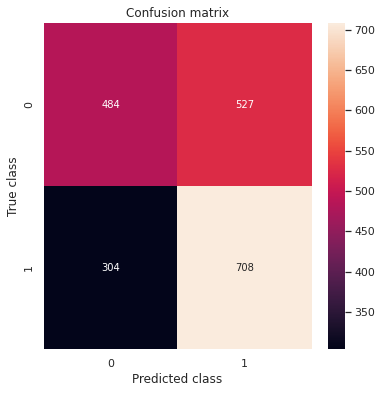

4
774
237
582
430
Total de datos:  2023
Total Perros:  1012
Aciertos:  1204   60.0 %
Fallos:  819   40.0 %
Perros acertados:  430   42.0 %
Perros fallidos:  582   57.99999999999999 %
Gatos fallidos:  237   36.0 %
Gatos acertados:  774   77.0 %


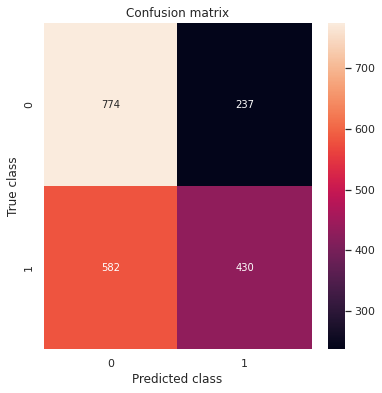

5
780
231
596
416
Total de datos:  2023
Total Perros:  1012
Aciertos:  1196   59.0 %
Fallos:  827   41.0 %
Perros acertados:  416   41.0 %
Perros fallidos:  596   59.0 %
Gatos fallidos:  231   36.0 %
Gatos acertados:  780   77.0 %


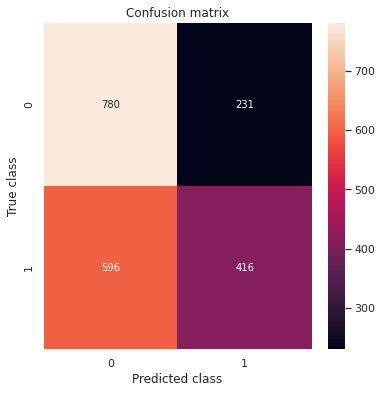

6
665
346
494
518
Total de datos:  2023
Total Perros:  1012
Aciertos:  1183   57.99999999999999 %
Fallos:  840   42.0 %
Perros acertados:  518   51.0 %
Perros fallidos:  494   49.0 %
Gatos fallidos:  346   40.0 %
Gatos acertados:  665   66.0 %


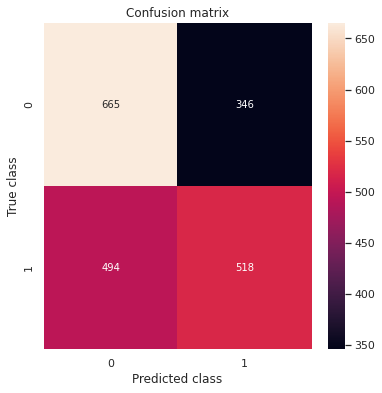

7
715
296
529
483
Total de datos:  2023
Total Perros:  1012
Aciertos:  1198   59.0 %
Fallos:  825   41.0 %
Perros acertados:  483   48.0 %
Perros fallidos:  529   52.0 %
Gatos fallidos:  296   38.0 %
Gatos acertados:  715   71.0 %


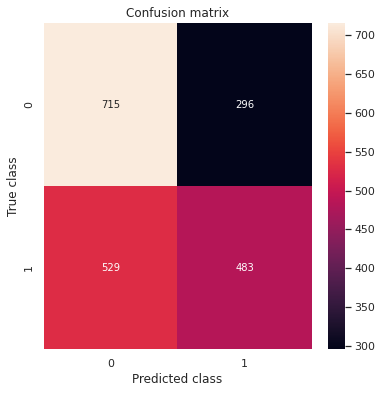

8
730
281
537
475
Total de datos:  2023
Total Perros:  1012
Aciertos:  1205   60.0 %
Fallos:  818   40.0 %
Perros acertados:  475   47.0 %
Perros fallidos:  537   53.0 %
Gatos fallidos:  281   37.0 %
Gatos acertados:  730   72.0 %


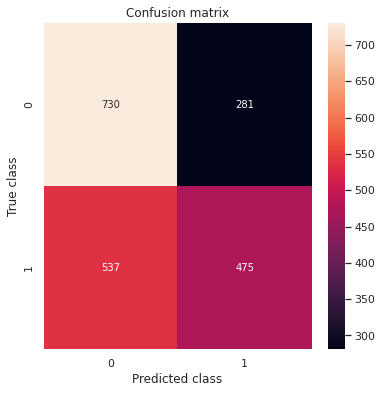

9
670
341
498
514
Total de datos:  2023
Total Perros:  1012
Aciertos:  1184   59.0 %
Fallos:  839   41.0 %
Perros acertados:  514   51.0 %
Perros fallidos:  498   49.0 %
Gatos fallidos:  341   40.0 %
Gatos acertados:  670   66.0 %


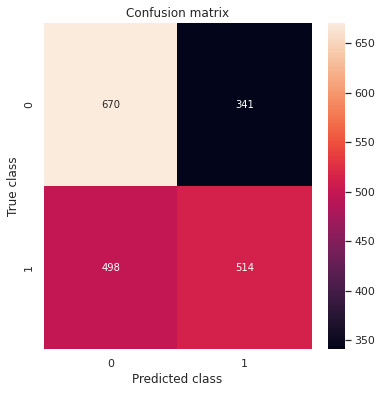

In [ ]:
#Configuración y ajuste de modelo, variando profundidad del arbol
for x in range(1,10):
  print(x)
  model = DecisionTreeClassifier(max_depth=x)
  model.fit(X_trainReshaped, y_trainTREE)
  y_predic = model.predict(X_testReshaped)
  print("Accuracy Score")
  print(accuracy_score(y_testTREE,y_predic))
  print("Classification Report")
  print(classification_report(y_testTREE,y_predic))
  mostrar_resultados(y_testTREE, y_predic)